In [1]:
import pandas as pd
import glob
import os
from datetime import datetime, timedelta

In [16]:
%matplotlib inline

In [10]:
months = ["03", "04"]
years = ["2019", "2019"]

In [11]:
def clean_delay_to_minutes(sec):
    if sec < 0:
        return 0.0
    else:
        return sec/60.0

In [12]:
def adjust_actual_times(row):
    row["delay_minutes"] = clean_delay_to_minutes(row["delay_minutes"])

    if row["delay_minutes"] > 700:
        
        # if delay ~= 1400, parsing error, subtract full day
        if row["delay_minutes"] > 1400:
            row["actual_time"] = row["actual_time"] - timedelta(hours=24)
        
        # if delay ~= 720, parsing error, subtract half day
        else:
            row["actual_time"] = row["actual_time"] - timedelta(hours=12)
        
        # recompute delay
        row["delay_minutes"] = (row["actual_time"] - row["scheduled_time"]).total_seconds()
        row["delay_minutes"] = clean_delay_to_minutes(row["delay_minutes"])

        return row
    
    return None

In [13]:
for month, year in zip(months, years):
    
    # read in CSVs for month
    path = "/Users/pranav/Documents/development/njtransit/csv/{}_{}".format(year, month)
    monthFiles = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in sorted(monthFiles)))
    print("done reading csv {}".format(month))
    
    # series-wide operations
    df.columns = ["train_id", "date", "stop_sequence", "from", "from_id", "to", "to_id", "scheduled_time", "actual_time", "status", "line", "type"]
    df['scheduled_time'] = pd.to_datetime(df['scheduled_time'])
    df['actual_time'] = pd.to_datetime(df['actual_time'])
    df['delay_minutes']=(df['actual_time']-df['scheduled_time']).dt.total_seconds()
    print("done series-wide {}".format(month))
    
    # adjust/clean times
    df_records = df.to_dict('records')
    for idx, record in enumerate(df_records):
        record = adjust_actual_times(record)
        if record is not None:
            df_records[idx] = record
    print("done adjust/clean {}".format(month))
    
    # generate cleaned df
    df = pd.DataFrame(df_records)
    columns = ["date", "train_id", "stop_sequence", "from", "from_id", "to", "to_id", "scheduled_time", "actual_time", "delay_minutes", "status", "line", "type"]
    df = df[columns]
    df.to_csv("/Users/pranav/Documents/development/njtransit/csv/monthly/{}_{}.csv".format(year, month), index=False)
    print("done generating df {}".format(month))

done reading csv 03
done series-wide 03
done adjust/clean 03
done generating df 03
done reading csv 04
done series-wide 04
done adjust/clean 04
done generating df 04


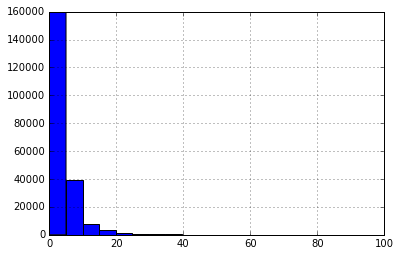

In [19]:
df[df["delay_minutes"]<100]["delay_minutes"].hist(bins=20)